# 폐렴을 진단해보자

## Step 1. 실험환경 Set-up

In [27]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 필요한 변수 생성

In [28]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 20
EPOCHS = 30

## Step 2. 데이터 준비하기

In [29]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("train : ", len(train_filenames))
print("test : ", len(test_filenames))
print("val : ", len(val_filenames))

train :  5216
test :  624
val :  16


* val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져 옴.

In [30]:
# train 데이터와 validation 데이터를 모두 filenames에 모음.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눔.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("train : ", len(train_filenames))
print("val : ", len(val_filenames))

train :  4185
val :  1047


### train 데이터 안에 정상 이미지 수와 폐렴 이미지 수 확인
* 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지
* 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지

In [31]:
# 경로에 따른 이미지 확인 예시
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [32]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


### mini-batch
* Training data 에서 일정한 크기 ( == Batch size ) 의 데이터를 선택하여 Cost function 계산 및 Gradient descent 적용
* 설계자의 의도에 따라 속도와 안정성을 동시에 관리할 수 있으며, GPU 기반의 효율적인 병렬 연산이 가능

In [33]:
# tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줌.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [34]:
# Train 데이터셋, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 파일 경로 이용 라벨 데이터를 만들어 주는 함수 만들기 

In [35]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있음.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 이미지의 사이즈를 통일
* decode_img 함수와 process_path 함수 만들기
* process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경, get_label을 이용해서 라벨 값을 가져옴.

In [36]:
# 이미지를 알맞은 형식으로 바꿈
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### train 데이터 셋과 validation 데이터 셋 만들기

In [37]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [38]:
# 이미지 리사이즈 및 라벨 확인 
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


###  test 데이터셋 만들기

In [39]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f"Test images count: {TEST_IMAGE_COUNT}")

Test images count: 624


### tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환
* shuffle()을 사용 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택.
* repeat()으로 여러 번 데이터셋을 사용할 수 있게 함.
* batch()를 사용 BATCH_SIZE에서 정한 만큼의 배치로 지정.
* prefetch()으로 학습 데이터를 나눠서 읽어 오도록 - 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음.

In [40]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화
* 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출.
* 추출된 배치를 image와 label 데이터 셋으로 나눔.
* show_batch() 함수를 이용해서 결과 사진을 봄.

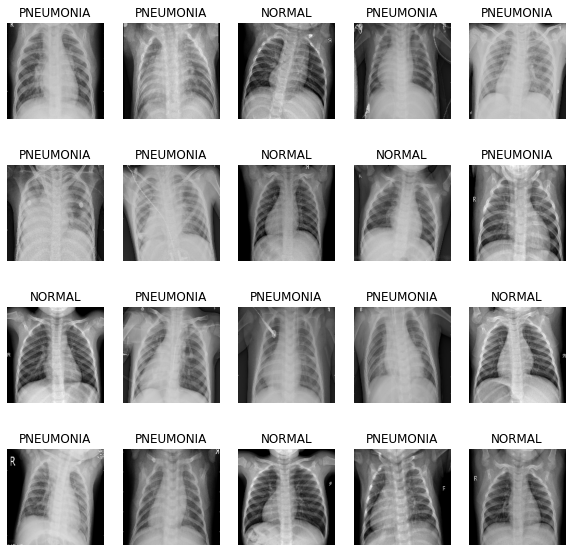

In [41]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줌 - 좌우 반전 여부 확인가능
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

* 20개의 배치 이미지 중 좌우 전환된 이미지 확인 됨.

## Step 4. CNN 모델링
[CNN, Convolutional Neural Network 요약](http://taewan.kim/post/cnn/)

In [42]:
# Convolution block 만들기

def conv_block(filters): 
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'), # Convolution(합성곱)을 두번 진행
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(), # Batch Normalization을 통해 Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D() # Max Pooling 레이어를 통해 행렬의 크기 감소, 채널 수 변경 없음
    ])
    
    return block

In [43]:
# Dense Block 만들기
# Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [44]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.15),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.15),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리
[딥러닝에서 클래스 불균형을 다루는 방법](https://3months.tistory.com/414)

In [45]:
#  weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

In [46]:
with tf.device('/GPU:0'):   # 이미지 훈련은 GPU를 사용
    model = build_model()  # 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언

    # 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이미지의 라벨이 두 개 이므로 "binary_cross entropy" loss를 사용
        metrics=METRICS
    )

In [47]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
209/209 [==============================] - 141s 570ms/step - loss: 0.3855 - accuracy: 0.8057 - precision: 0.9556 - recall: 0.7750 - val_loss: 0.6626 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/30
209/209 [==============================] - 119s 571ms/step - loss: 0.2306 - accuracy: 0.9093 - precision: 0.9733 - recall: 0.9029 - val_loss: 0.9625 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/30
209/209 [==============================] - 116s 555ms/step - loss: 0.1901 - accuracy: 0.9306 - precision: 0.9783 - recall: 0.9274 - val_loss: 1.5358 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/30
209/209 [==============================] - 118s 566ms/step - loss: 0.1690 - accuracy: 0.9368 - precision: 0.9798 - recall: 0.9344 - val_loss: 0.5074 - val_accuracy: 0.7731 - val_precision: 0.7635 - val_recall: 1.0000
Epoch 5/30
209/209 [==============================] - 98s 472ms/step - loss: 0.1535 - ac

## Step 7. 결과 확인과 시각화
* 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줌

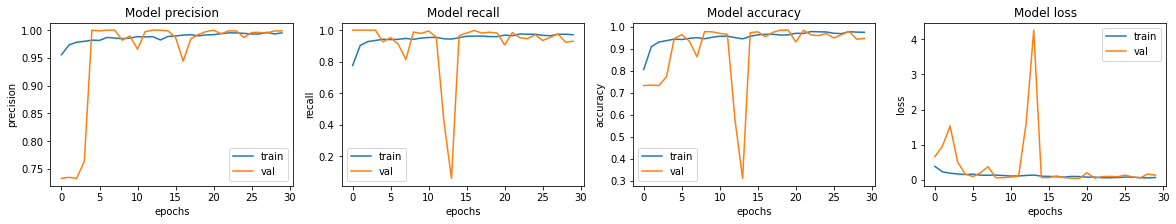

In [48]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [49]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

32/32 [==============================] - 5s 154ms/step - loss: 0.8931 - accuracy: 0.8093 - precision: 0.7865 - recall: 0.9538
Loss: 0.8930650353431702,
Accuracy: 0.8092948794364929,
Precision: 0.7864693403244019,
Recall: 0.9538461565971375


## 후기

#### 아래와 같이 변경 후 테스트 데이터로 모델 평가 한 결과는
>BATCH_SIZE = 20<br>
>EPOCHS = 30<br>
>augmentation 기법 적용(좌우 반전)<br>
>Dropout 비율 0.15로 변경<br>
* Accuracy: 0.8092948794364929<br>
* Recall: 0.9538461565971375

augmentation 기법 적용이 모델 성능을 크게 향상시키지는 못하는 것으로 생각 됨.<br>
Convolution block 에서 Convolution(합성곱) 횟수를 증가시키는 등으로 변경하고 싶으나 모델에 대한 이해도가 부족하여 실행하지 못함.

#### Exploration9 예문 조건대로 했을 때 테스트 데이터로 모델 평가 한 결과는
* Accuracy: 0.7756410241127014<br>
* Recall: 0.9820512533187866

#### Exploration9 예문 조건에  Dropout 비율만 0.15로 변경 결과는 Recall 값만 0.015 높아졌었음.
* Accuracy: 0.7756410241127014<br>
* Recall: 0.9974358677864075

진단의 경우 Recall의 지표가 매우 중요한 평가지표중 하나인데
> FN 즉 양성을 음성으로 인식하는 비율이 높으면 Recall의 지표가 낮아지므로 Recall의 지표가 높은것이 좋은 모델

Dropout 비율이 Recall 값에 영향을 주는 것 같아 보였으나 수치차이가 작아 확실하지 않음.